# Entregas

1. EDA  
**R:** A análise exploratória se encontra no bloco abaixo

2. Perguntas  
2.1. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?  
**R:** É mais indicado comprar em **Manhattan**, pois os preços de aluguel lá costumam ser maiores, além de que os apartamentos lá apresentam em média poucos dias disponíveis no ano, quando comparado com outros bairros, indicando uma alta demanda.  
2.2. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?  
**R:** Apartamentos com número mínimo de noites menor apresentam uma maior variedade de preços, enquanto um número mínimo de noites maior apresentam normalmente preços mais baixos. Quanto a disponibilidade ao longo do ano, a análise foi inconclusiva.  
2.3. Existe algum padrão no texto do nome do local para lugares de mais alto valor?  
**R:** Também não foi possível perceber nenhum padrão sobre o nome do local e sua relação com o preço.  

3. Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?  

**R:** A partir da EDA e dos testes com diferentes modelos, foram escolhidas usar as variáveis de bairro, bairro_group, room_type, minimo_noites, disponibilidade_365, numero_de_reviews, pois mostraram ter algum tipo de relação com o preço, melhorando a acurácia do modelo.  

Para agregar mais valor às informações de latitude e longitude, foi criada uma nova métrica, chamada de soma_distancias. A partir de uma base de dados de NY chamada Points of Interest, calculei a soma da distância do apartamento aos 5 pontos de interesse mais próximos. Esses pontos incluem tudo que diferentes agentes do governo acham interessantes, como alguns prédios, pontos de ônibus, metrô, jardins, parques etc.A minha ideia ao fazer isso é de que apartamentos pertos de mais pontos de interesse seriam mais caros. Não foi possível ver uma melhora significativa na acurácia do modelo, mas creio que caberia testar o ajuste desse número escolhido (5), além de filtrar a tabela de pontos de interesse. Meus recursos computacionais foram insuficientes para que eu pudesse seguir com esses testes em tempo hábil. 

De maneira geral, o caminho é tratar os dados, remover outliers, valores nulos, tratar os dados não-numéricos, escolher um modelo e ajustar os seus parâmetros.

É um problema do tipo **regressão**, pois queremos prever o preço do aluguel, que é um valor contínuo. O melhor modelo identificado foi o **Random Forest Regressor (RFR)**. A vantagem dele é que lida bem com relações não lineares e resiste à *overfitting*. Suas desvantagens são que pode ser lento para grandes volumes de dados e pode ser difícil de interpretar, por não apresentar coeficientes claros. A métrica escolhida foi o **R²**, o coeficiente de determinação, por nenhum motivo especial. É fácil de interpretar e de utilizar para comparar modelos distintos.

4. Sugestão de preço para apartamento específico  
**R:** Como pode ser visto no final do caderno, a sugestão de preço para o apartamento no enunciado é **$241**.



# EDA

## Análise Inicial

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../data/dataset.csv', index_col=0)
print(df.dtypes)

    

nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object


Observam-se 6 dados categóricos e 10 dados numéricos

In [3]:
print(df.head(2))

                                     nome  host_id  host_name bairro_group  \
id                                                                           
2595                Skylit Midtown Castle     2845   Jennifer    Manhattan   
3647  THE VILLAGE OF HARLEM....NEW YORK !     4632  Elisabeth    Manhattan   

       bairro  latitude  longitude        room_type  price  minimo_noites  \
id                                                                          
2595  Midtown  40.75362  -73.98377  Entire home/apt    225              1   
3647   Harlem  40.80902  -73.94190     Private room    150              3   

      numero_de_reviews ultima_review  reviews_por_mes  \
id                                                       
2595                 45    2019-05-21             0.38   
3647                  0           NaN              NaN   

      calculado_host_listings_count  disponibilidade_365  
id                                                        
2595                       

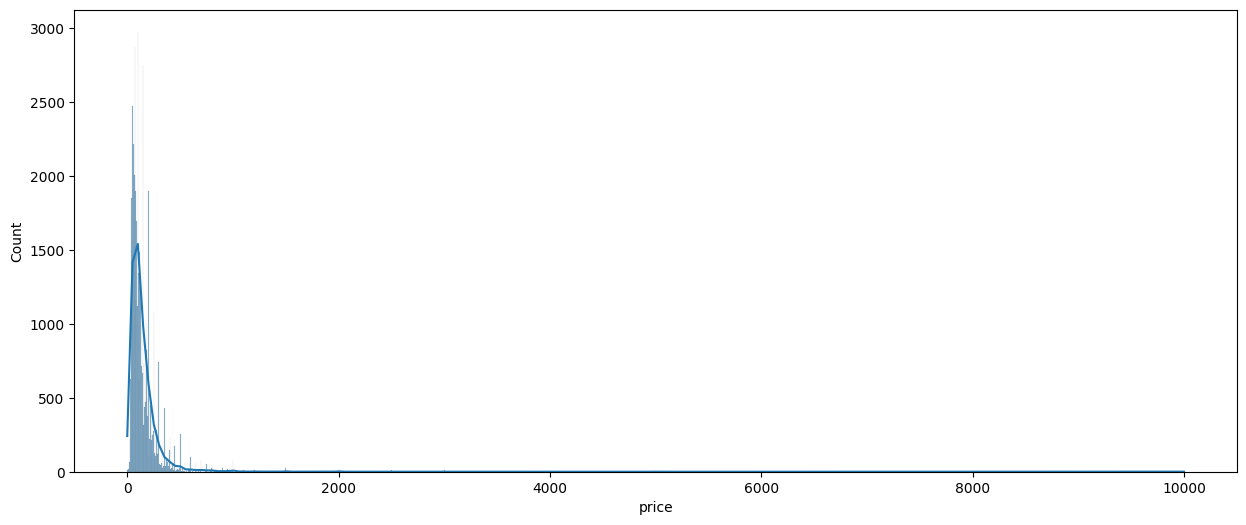

In [4]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df['price'], kde=True)
plt.show()


### Análise do room_type

<Axes: xlabel='room_type', ylabel='Count'>

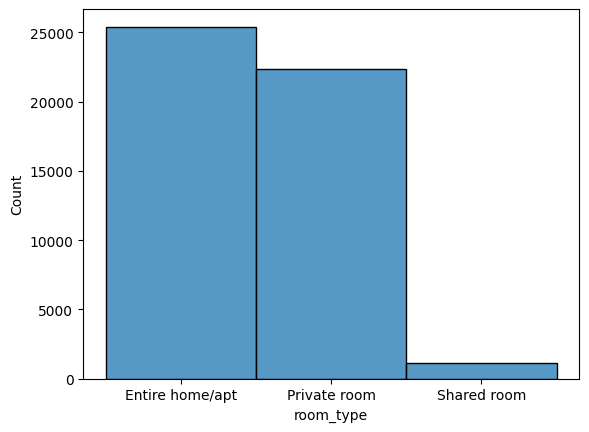

In [5]:
sns.histplot(data=df['room_type'])

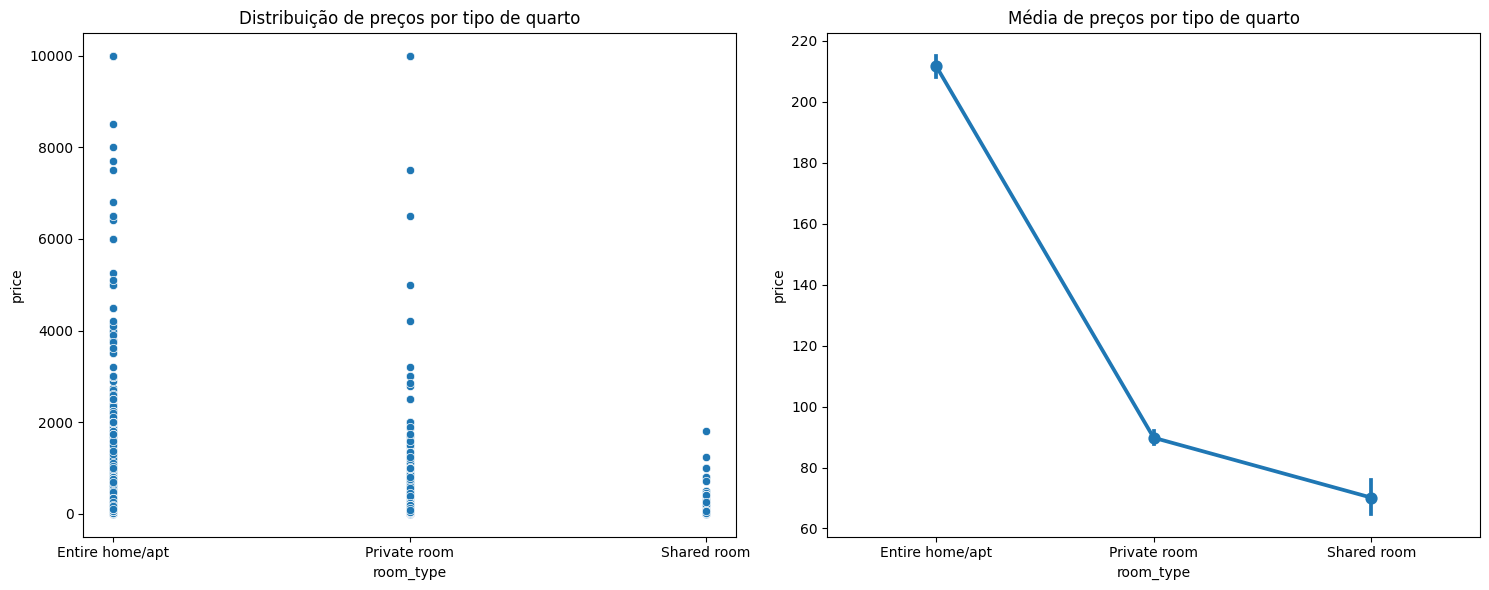

In [6]:
fig, axes = plt.subplots(1,2, figsize=(15, 6))
sns.scatterplot(x='room_type', y='price', data=df, ax=axes[0])
axes[0].set_title('Distribuição de preços por tipo de quarto')

sns.pointplot(x='room_type', y='price', data=df, estimator='mean', ax=axes[1])
axes[1].set_title('Média de preços por tipo de quarto')
plt.tight_layout()
plt.show()


Como esperado, os apartamentos inteiros atingem preços mais altos do que quartos privativos, que, por sua vez, atingem preços mais altos que os quartos compartilhados. A média de preços segue essa ordem também. Parece que as pessoas estão dispostas a pagar mais por sua privacidade

### Análise de outros parâmetros

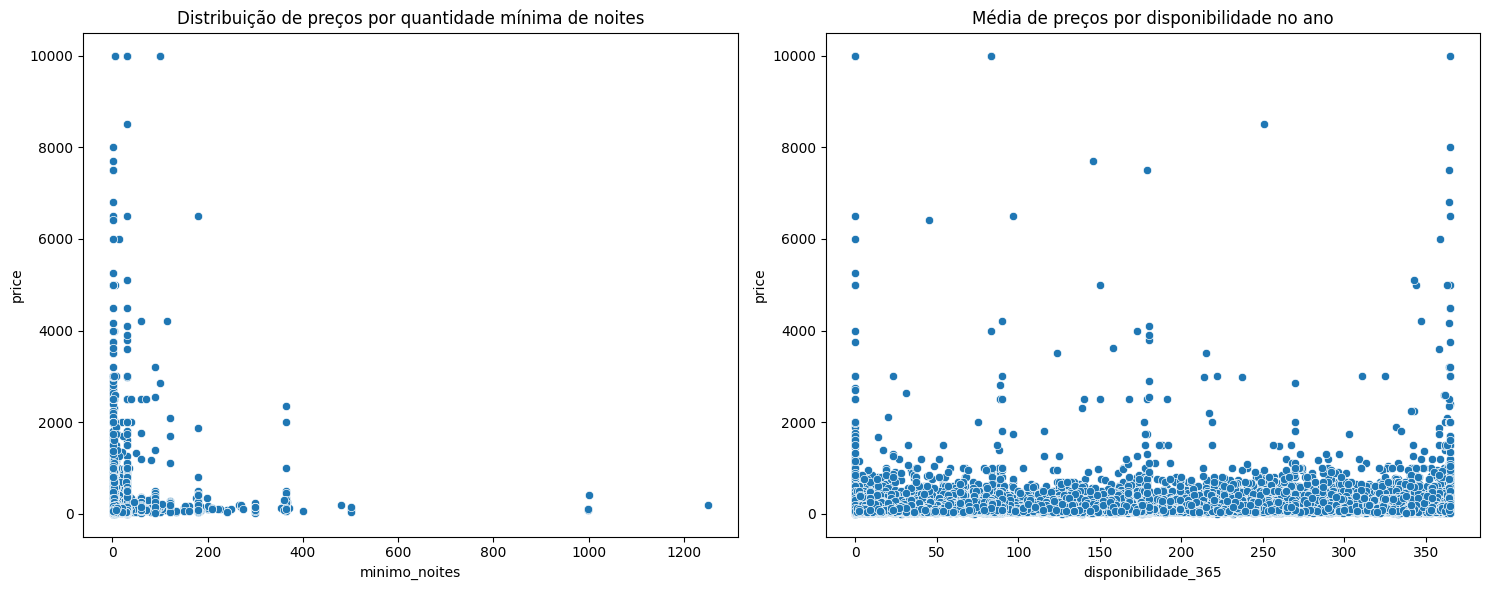

In [7]:
fig, axes = plt.subplots(1,2, figsize=(15, 6))
sns.scatterplot(x='minimo_noites', y='price', data=df, ax=axes[0])
axes[0].set_title('Distribuição de preços por quantidade mínima de noites')

sns.scatterplot(x='disponibilidade_365', y='price', data=df, ax=axes[1])
axes[1].set_title('Média de preços por disponibilidade no ano')
plt.tight_layout()
plt.show()


Pode-se concluir que os quartos com mínimo de noites menor possuem uma variedade de preços maior. Já não é possível inferir muito sobre a relação entre a disponibilidade e o preço.

## Análise de bairros

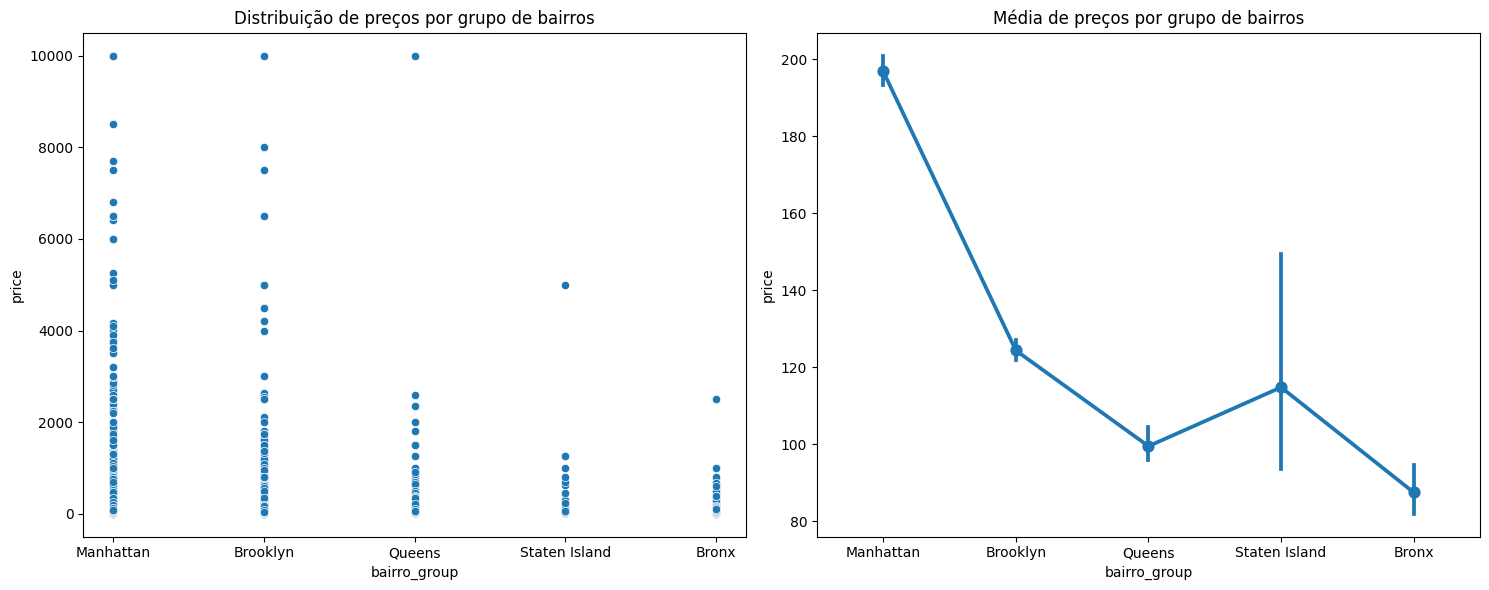

In [8]:
fig, axes = plt.subplots(1,2, figsize=(15, 6))
sns.scatterplot(x='bairro_group', y='price', data=df, ax=axes[0])
axes[0].set_title('Distribuição de preços por grupo de bairros')

sns.pointplot(x='bairro_group', y='price', data=df, estimator='mean', ax=axes[1])
axes[1].set_title('Média de preços por grupo de bairros')
plt.tight_layout()
plt.show()

Removendo os outliers, fica claro que os bairros Manhattan e Brooklyn são os que apresentam os aluguéis mais caros, e que Queens, Staten Island e Bronx, os mais baixos. Assim, o bairro_group se mostra um parâmetro muito relevante para o modelo preditivo.

Analisaremos agora a influência do bairro dentro de cada bairro_group

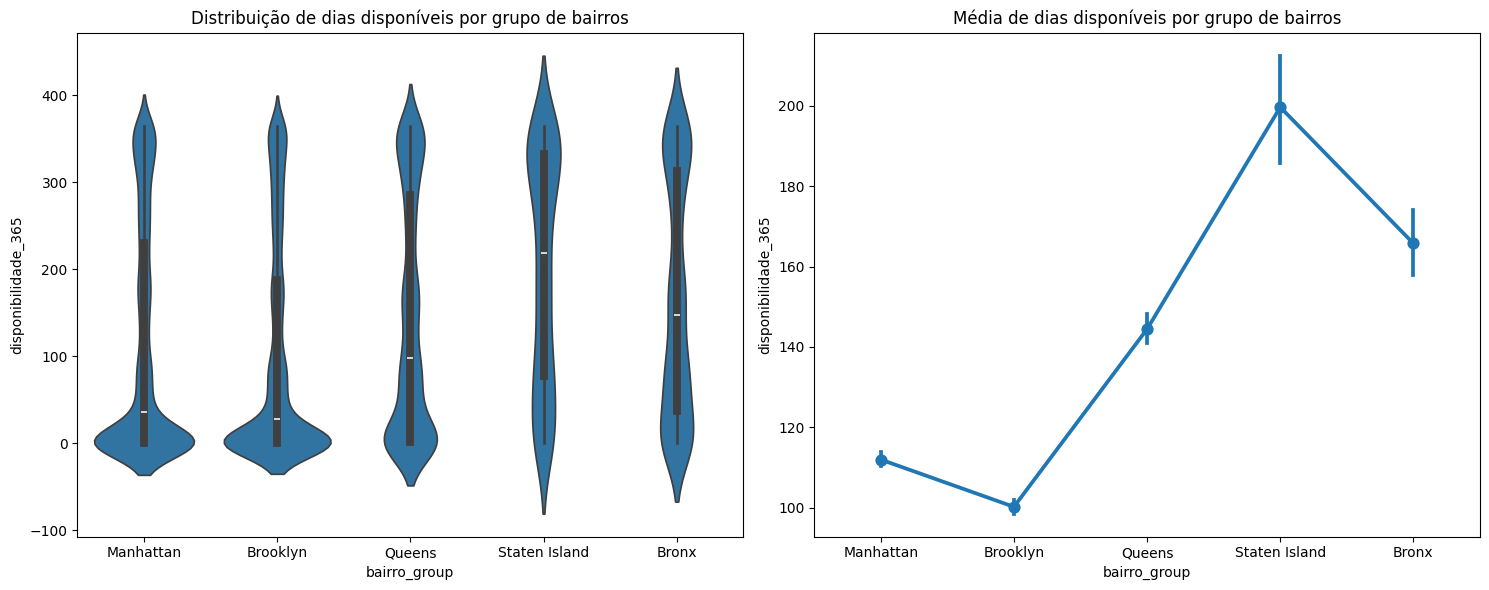

In [9]:
fig, axes = plt.subplots(1,2, figsize=(15, 6))
sns.violinplot(x='bairro_group', y='disponibilidade_365', data=df, ax=axes[0])
axes[0].set_title('Distribuição de dias disponíveis por grupo de bairros')

sns.pointplot(x='bairro_group', y='disponibilidade_365', data=df, estimator='mean', ax=axes[1])
axes[1].set_title('Média de dias disponíveis por grupo de bairros')
plt.tight_layout()
plt.show()

Curiosamente, os bairros mais caros (Manhattan e Brooklyn) são os que menos têm dias disponíveis, em média, mostrando uma alta demanda.

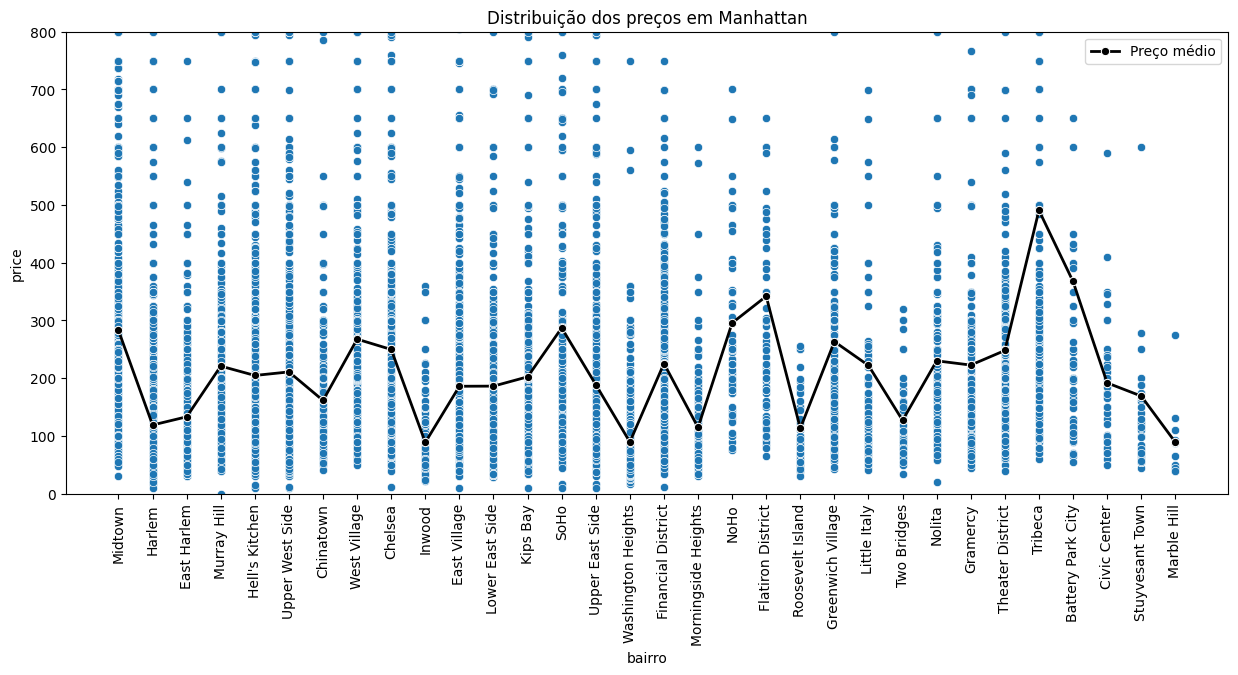

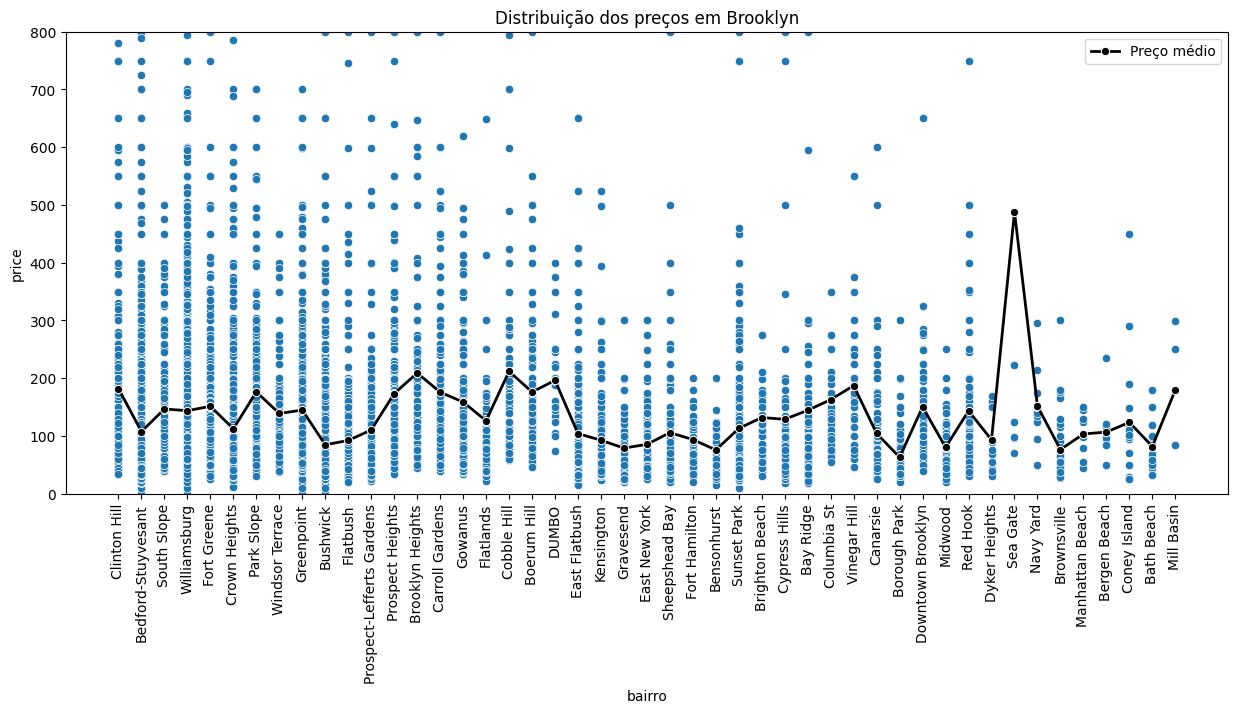

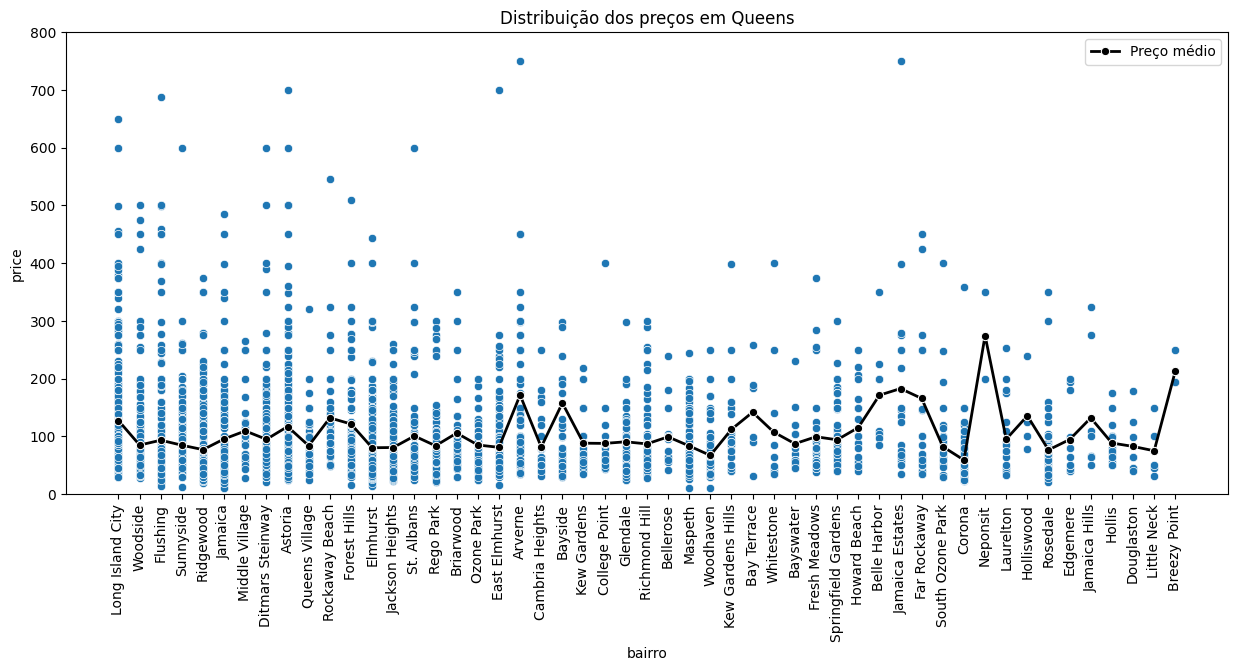

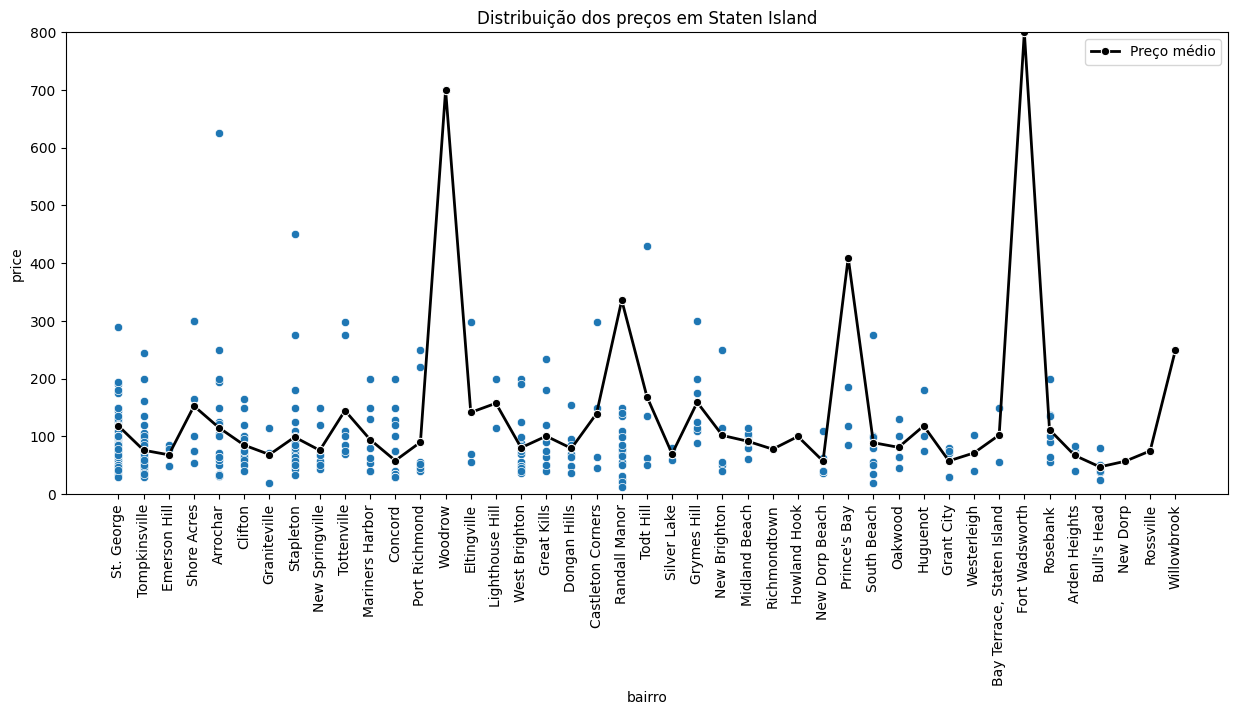

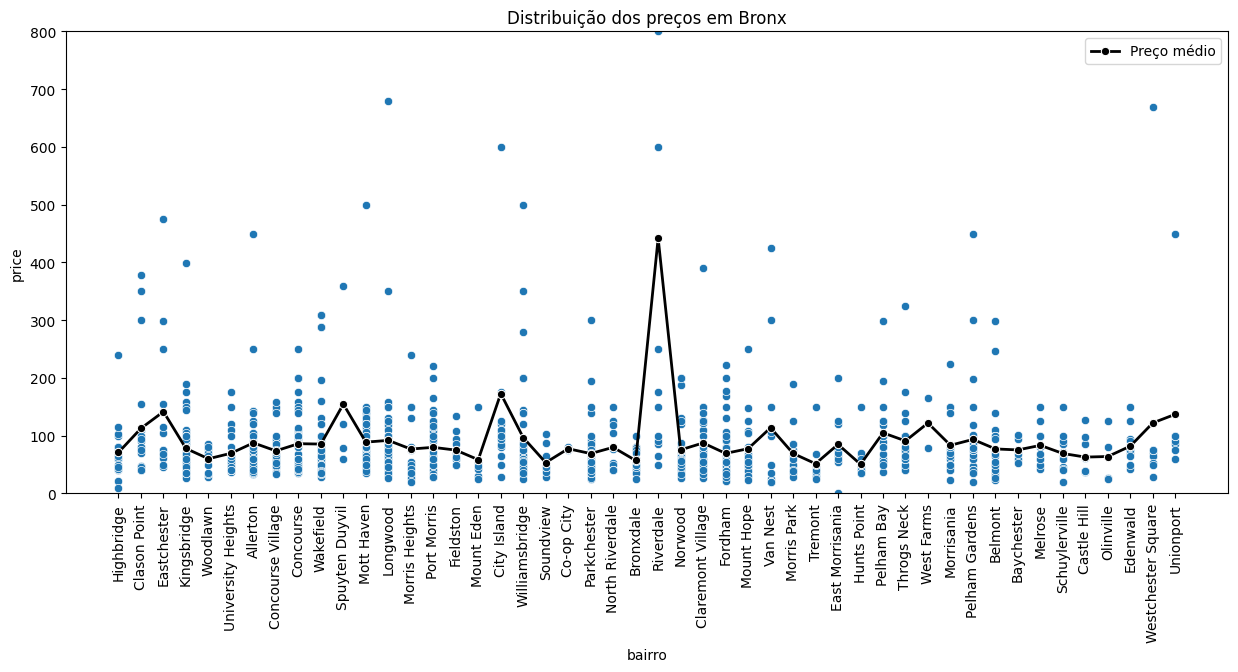

In [10]:
nomes_unicos_bairro = df['bairro_group'].unique()
for bairro in nomes_unicos_bairro:
    df_bairro = df[df['bairro_group'] == bairro]
    
    # df_bairro = df_bairro[['minimo_noites','reviews_por_mes','price']]
    # print(f"Estatísticas descritivas para o bairro: {bairro}")
    # print(df_bairro.describe())
    # print("\n" + "-"*50 + "\n")
    
    preco_medio = df_bairro.groupby('bairro')['price'].mean().reset_index()
    
    
    plt.figure(figsize=(15, 6))
    sns.scatterplot(x='bairro', y='price', data=df_bairro) 
    sns.lineplot(x='bairro', y='price',data=preco_medio, color='black', marker='o', linewidth=2, label="Preço médio")
    plt.title(f'Distribuição dos preços em {bairro}')
    plt.xticks(rotation=90)
    plt.ylim(top=800, bottom=0) # para mostrar o preço médio mais detalhado
    plt.show()

Pode-se ver que há um desvio significativo da média dos preços em cada bairro dentro de um bairro_group, principalmente em Manhattan e Staten Island. Os modelos testados posteriormente confirmaram que o bairro é uma informação relevante. 

## Analisando os aluguéis mais caros

          price                                               nome
id                                                                
22436899  10000                                1-BR Lincoln Center
13894339  10000    Luxury 1 bedroom apt. -stunning Manhattan views
7003697   10000                Furnished room in Astoria apartment
31340283   9999  2br - The Heart of NYC: Manhattans Lower East ...
4737930    9999                                 Spanish Harlem Apt
...         ...                                                ...
9775397    1200                    Apartment at the St.Regis Hotel
11359913   1200                                 Gramercy Townhouse
27161388   1200                                Brooklyn Town House
32317538   1200       SPACIOUS Floor-Through Loft in Flatiron, NYC
24941609   1200   NY’s Highest End Celebrity Building + Balconies!

[200 rows x 2 columns]


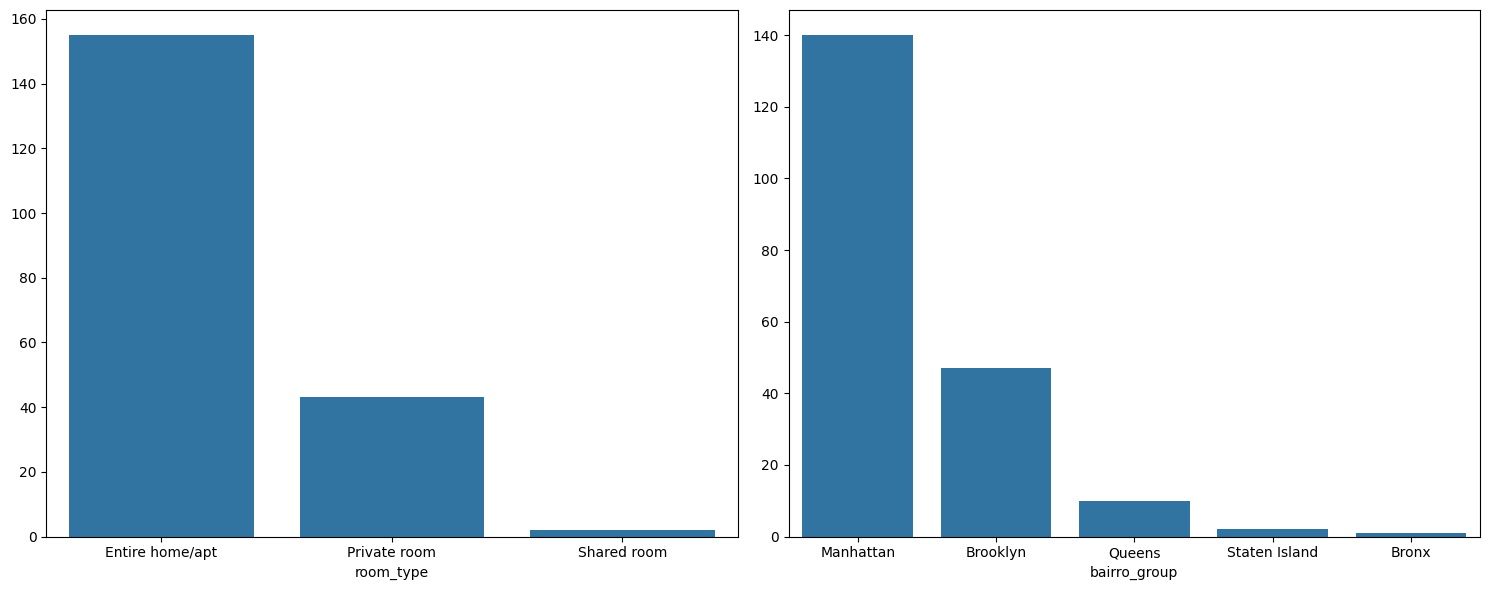

In [11]:
top_500_precos = df.sort_values(by='price', ascending=False).head(200)

print(top_500_precos[['price', 'nome']])

cont = top_500_precos['room_type'].value_counts()
contb = top_500_precos['bairro_group'].value_counts()

fig, axes = plt.subplots(1,2, figsize=(15,6))
sns.barplot(x=cont.index, y=cont.values, ax=axes[0])
sns.barplot(x=contb.index, y=contb.values, ax=axes[1])
plt.tight_layout()
plt.show()


A distribuição das quantidades entre os bairros e os tipos de quarto se mantém mesmo fazendo um recorte dos aluguéis mais caros.

Não é possível perceber um padrão dos nomes dos apartamentos mais caros.

# O Modelo

## Removendo Outliers

In [12]:
df = pd.read_csv('../data/incremented_dataset.csv', index_col=0)
 
used_columns = ['soma_distancias','bairro_group','bairro','room_type','price', 'minimo_noites', 'numero_de_reviews', 'disponibilidade_365']
df_intermediario = df[used_columns]

for column in ['price', 'minimo_noites', 'numero_de_reviews', 'disponibilidade_365']:
  Q1 = df_intermediario[column].quantile(0.15)
  Q3 = df_intermediario[column].quantile(0.85)
  IQR = Q3 - Q1

  # Filtra os valores fora do intervalo IQR
  df_intermediario = df_intermediario[(df_intermediario[column] >= Q1 - 1.5 * IQR) & (df_intermediario[column] <= Q3 + 1.5 * IQR)]

print(df_intermediario.describe())  

       soma_distancias         price  minimo_noites  numero_de_reviews  \
count     40368.000000  40368.000000   40368.000000       40368.000000   
mean          0.736432    128.044937       3.012659          18.096884   
std           0.381551     83.171536       2.554708          27.311072   
min           0.021981      0.000000       1.000000           0.000000   
25%           0.461466     67.000000       1.000000           1.000000   
50%           0.656699    100.000000       2.000000           6.000000   
75%           0.925700    165.000000       4.000000          23.000000   
max           5.031295    480.000000      16.000000         132.000000   

       disponibilidade_365  
count         40368.000000  
mean             94.579221  
std             124.177782  
min               0.000000  
25%               0.000000  
50%              20.000000  
75%             175.000000  
max             365.000000  


## Transformando dados categóricos em numéricos

In [13]:
from sklearn.preprocessing import OneHotEncoder

s = (df_intermediario.dtypes == 'object')
object_cols = list(s[s].index)

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df_intermediario[object_cols]))
OH_cols.index = df_intermediario.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = df_intermediario.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)


print(df_final.dtypes)

soma_distancias              float64
price                          int64
minimo_noites                  int64
numero_de_reviews              int64
disponibilidade_365            int64
                              ...   
bairro_Woodlawn              float64
bairro_Woodside              float64
room_type_Entire home/apt    float64
room_type_Private room       float64
room_type_Shared room        float64
Length: 232, dtype: object


Foi utilizado o One Hot Encoder para transformar as colunas categóricas, como bairro_group, bairro e room_type em colunas com valores numéricos. Em vez de atribuir um valor para cada categoria, como 1 para Manhattan, 2 para Bronx etc, cria-se uma coluna de 0 ou 1 para cada categoria. Dessa forma, não há um peso implícito atrelado à categoria.

## Divindo dados de treino e dados de teste

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()

# X = scaler.fit_transform(df_final.drop(['price'], axis=1))
# Y = scaler.fit_transform(df_final['price'].values.reshape(-1, 1)).ravel()

X = df_final.drop(['price'], axis=1)
Y = df_final['price'].values.reshape(-1, 1).ravel()

X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, train_size=0.8, test_size=0.2, random_state=0)


Retira 20% dos dados para serem usados como dados de validação. Resolveu-se não normalizar os dados porque foi percebido que não houve melhora na acurácia do modelo. 

## Modelos

In [15]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn import svm
# from sklearn.linear_model import LinearRegression

model_RFR = RandomForestRegressor(
min_samples_leaf = 1, 
min_samples_split = 10, 
n_estimators = 100, 
max_depth = 50, 
max_features = 'sqrt', 
bootstrap = True, 
random_state=13)


In [23]:
model_RFR.fit(X_train, Y_train)
Y_pred_RFR = model_RFR.predict(X_valid)
print('RFR R² = ', model_RFR.score(X_valid, Y_valid))

RFR R² =  0.5018173852271932


In [22]:
import pickle

with open("../model/model.pkl", "wb") as f:
  pickle.dump(model_RFR, f)

## Validando o modelo escolhido

In [17]:
df_resultados = pd.DataFrame({
  "Valores reais": Y_valid.reshape(-1, 1).ravel(),
  "Valores previstos": Y_pred_RFR.reshape(-1, 1).ravel() 
})

print(df_resultados[10:20])

    Valores reais  Valores previstos
10             65          70.223326
11             50          58.567182
12            209         150.564722
13             60          62.439646
14             55          66.792958
15            200         156.479544
16             56         101.419211
17             64         103.649253
18            112          62.196781
19             74         140.032232


## Prevendo o preço do apartamento do case 

Esse trecho é o que utiliza a tabela Points_of_Interest.csv para agregar mais valor aos valores de latitude e longitude. A parte comentada é a que gerou a tabela incremented_dataset, utilizada para treinar o modelo.

In [18]:
import pandas as pd
import numpy as np

pricing_df = pd.read_csv('../data/dataset.csv')
poi_df = pd.read_csv("../data/Points_of_Interest.csv")

def extract_coordinates(point_str):
    coords = point_str.replace("POINT (", "").replace(")", "").split()
    longitude = float(coords[0])
    latitude = float(coords[1])
    return latitude, longitude
  
poi_df[['latitude', 'longitude']] = poi_df['the_geom'].apply(extract_coordinates).apply(pd.Series)

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Fórmula de Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    R = 6371  # Raio da Terra
    distance = R * c
    return distance
  
def sum_of_nearest_distances(row, poi, n=5):
    lat2, lon2 = row['latitude'], row['longitude']
    
    distances = poi.apply(lambda x: haversine(lat2, lon2, x['latitude'], x['longitude']), axis=1)
    nearest_distances = distances.nsmallest(n)
    return nearest_distances.sum()

# Calcula a soma_distancias de todas as linhas da tabela dataset.csv e salva em incremented_dataset2.csv

# pricing_df['soma_distancias'] = pricing_df.apply(sum_of_nearest_distances, axis=1, poi=poi_df)
# print(pricing_df[['latitude', 'longitude', 'soma_distancias']].head())

# pricing_df.to_csv('../data/incremented_dataset2.csv')


In [19]:
apartamento_do_case = {'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355,
 }

apartamento_do_case['price'] = 0 # apenas para rodar os códigos abaixo

df_case = pd.DataFrame([apartamento_do_case])
df_case['soma_distancias'] = df_case.apply(sum_of_nearest_distances, axis=1, poi=poi_df)

df_case = df_case[used_columns]

df_case = pd.concat([df_case, OH_cols[:1]], axis=1)
df_case[f'bairro_{apartamento_do_case["bairro"]}'] = 1.
df_case[f'bairro_group_{apartamento_do_case["bairro_group"]}'] = 1.
df_case[f'room_type_{apartamento_do_case["room_type"]}'] = 1.

df_case = df_case.drop(['bairro', 'bairro_group', 'room_type', 'price'], axis=1)

result = model_RFR.predict(df_case)
print(result)


[241.16163818]


Assim, o preço previsto para o apartamento pedido é de $241

# Conclusão

Os dados fornecidos não foram suficientes para criar um modelo muito preciso, mesmo fazendo diversas tratativas dos dados e usando uma tabela auxiliar.  

Uma base de dados maior ou com parâmetros mais significativos poderiam trazer melhores resultados, em um segundo trabalho neste tópico.